Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).

Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.

Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

Задание 3: использовать permutation importance, выполнить задание 1 и 2.

Задание 4: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.

Задание 5: использовать shap, выполнить задание 1 и 2.

Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

In [209]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, probplot
from sklearn.model_selection import TimeSeriesSplit
import catboost as cb

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score, ShuffleSplit, learning_curve, GroupKFold
import missingno as msno
warnings.simplefilter("ignore")
%matplotlib inline

import gc # сборщик мусора
import pickle

In [210]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [211]:
PATH = 'C:/Users/Kokorozaci/Downloads/assignment2_data/'
train = pd.read_csv(PATH + "assignment_2_train.csv")
test = pd.read_csv(PATH + "assignment_2_test.csv")
print("data.shape = {} rows, {} cols".format(*train.shape))
train.head(n=2)

data.shape = 180000 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
y_train = train["isFraud"]
y_test = test["isFraud"]
x_train = train.set_index('TransactionID')
x_train = train.drop("isFraud", axis=1)
x_test = test.set_index('TransactionID')
x_test = test.drop("isFraud", axis=1)
print("data.shape = {} rows, {} cols".format(*train.shape), "data.shape = {} rows, {} cols".format(*test.shape))

data.shape = 180000 rows, 394 cols data.shape = 100001 rows, 394 cols


In [213]:
def GroupKFold_val(X, y, n_split, group):
    
    val_train = []
    val_test = []
    
    group_kfold = GroupKFold(n_splits=n_split)
    
    for train_index, test_index in group_kfold.split(X, y, groups=X[group]):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        dtest = xgb.DMatrix(
                data=X_test, label=y_test
            )

        dtrain = xgb.DMatrix(
                data=X_train, label=y_train
            )

        params = {
            "booster": "gbtree",
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "learning_rate": 0.1,
            "n_estimators": 1000,
            "reg_lambda": 100,
            "max_depth": 4,
            "gamma": 10,
            "nthread": 6,
            "seed": 27
            }

        model = xgb.train(
                params=params,
                dtrain=dtrain,
                num_boost_round=10000,
                early_stopping_rounds=50,
                evals=[(dtrain, "train"), (dtest, "valid")],
                verbose_eval=None,
                maximize=True,
            )

        train_score = roc_auc_score(y_train, model.predict(dtrain))
        test_score = roc_auc_score(y_test, model.predict(dtest))
        
        val_train.append(train_score)
        val_test.append(test_score)

        scores = create_bootstrap_metrics(y_test, model.predict(dtest), roc_auc_score)

        print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}")
        print(calculate_confidence_interval(scores))

    return val_train, val_test

In [214]:
class FrequencyEncoder:
    """FrequencyEncoder"""
    
    def __init__(self, categorical_features):
        self.categorical_features= categorical_features
        self.m = None
        
    def fit(self, X):
        self.m = {f: {} for f in self.categorical_features}
        for feature in self.categorical_features:
            self.m[feature] = X[feature].value_counts(normalize=True).to_dict()
    
    def transform(self, X): 
        for feature in self.categorical_features:
            X[f'{feature}_freq_encoding'] = X[feature].map(self.m[feature])

        return X

In [215]:
class CreateFeatures:
    
    def __init__(self):
        self.base_name = 'TransactionDT'
        self.base = '2017-12-01'
        
    def datetime_transform(self, df):
        X = df.copy()
        X[f'{self.base_name}_time'] = self.base
        X[f'{self.base_name}_time'] = pd.to_datetime(X[f'{self.base_name}_time']) + pd.to_timedelta(X[self.base_name], unit='s')
        X.set_index(f'{self.base_name}_time', inplace=True)
        X['Year'] = X.index.year
        X['Month'] = X.index.month
        X['Day of week'] = X.index.dayofweek
        X['Day'] = X.index.day
        X['Hour'] = X.index.hour
        X.reset_index(inplace=True)
        X.drop(f'{self.base_name}_time', axis=1, inplace=True)
        return X
    
    def new_category(self, df):
        X = df.copy()
        X['card1 + card2'] = X['card1'].astype('str') + ' | ' + X['card2'].astype('str') 
        X['card1 + card2 + card3 + card5'] = X['card1'].astype('str')  + ' | ' + X['card2'].astype('str')+ ' | '  + X['card3'].astype('str')  + ' | ' + X['card5'].astype('str') 
        X['card1 + card2 + card3 + card5 + addr1 + addr2'] = X['card1'].astype('str')  + ' | ' + X['card2'].astype('str')  + ' | '+ X['card3'].astype('str')  + ' | ' + X['card5'].astype('str')  + ' | ' + X['addr1'].astype('str')  + ' | ' + X['addr2'].astype('str') 
        return X
    
    def feature_ratio(self, X, features, group_list, stat_list):
        agg_dict = {feature: stat_list for feature in features}
        group_dict = {}
        for group in group_list:
            df = X.groupby(group, as_index=False).agg(agg_dict)
            df.columns = [f'{group}_{"_".join(x)}' for x in df.columns.ravel()]
            df = df.rename(columns={df.columns[0]:group})
            X = X.merge(df, on=[group], how='left')
        for feature in features:
            columns = [col for col in X.columns if feature in col]
            X[columns[1:]] = np.repeat([X[columns[0]].values], repeats=len(columns)-1, axis=0).T/ X[columns[1:]].values
        return X
    
    def feature_split(self, X):
        X['TransactionAmt_int'] = X['TransactionAmt']//1
        X['TransactionAmt_frac'] = X['TransactionAmt']%1
        X['TransactionAmt_log'] = np.log(X['TransactionAmt'])
        return X
    
    def emaildomain(self, X):
        X['P_emaildomain_name'] = X['P_emaildomain'].astype('str').str.split('.').apply(lambda s:s[0])
        X['P_emaildomain_domain'] = X['P_emaildomain'].astype('str').str.split('.').apply(lambda s:'.'.join(s[1:]))
        X['R_emaildomain_name'] = X['R_emaildomain'].astype('str').str.split('.').apply(lambda s:s[0])
        X['R_emaildomain_domain'] = X['R_emaildomain'].astype('str').str.split('.').apply(lambda s:'.'.join(s[1:]))
        X.loc[X['R_emaildomain_name'] == 'nan', 'R_emaildomain_name'] = np.NaN
        X.loc[X['R_emaildomain_domain'] == '', 'R_emaildomain_domain'] = np.NaN
        X.loc[X['P_emaildomain_name'] == 'nan', 'P_emaildomain_name'] = np.NaN
        X.loc[X['P_emaildomain_domain'] == '', 'P_emaildomain_domain'] = np.NaN
        X['P_R_domain'] = X['R_emaildomain_domain'] + ' | ' + X['P_emaildomain_domain']
        return X


    def transform(self, X):
        X = self.datetime_transform(X)
        X = self.new_category(X)
        group_list = ['card1', 'card2', 'card3', 'card4',
              'card5', 'card6', 'addr1', 'addr2',
              'card1 + card2', 'card1 + card2 + card3 + card5', 
              'card1 + card2 + card3 + card5 + addr1 + addr2']
        stat_list = ['mean', 'std']
        features = ['TransactionAmt', 'D15']
        X = self.feature_ratio(X, features, group_list, stat_list)
        X = self.feature_split(X)
        X = self.emaildomain(X)
        
        simple_features = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
        
        for feature in simple_features:
            if len(X[feature].value_counts()) == 2:
                X[feature] = pd.get_dummies(X[feature], drop_first=True)
            else:
                X[feature] = X[feature].map({v:k for k, v in enumerate(X.groupby(feature).count().index)})
                
        cat_features = X.select_dtypes(include=[np.object]).columns
        
        encoder = FrequencyEncoder(cat_features)
        encoder.fit(X)
        X = encoder.transform(X)
        X = X.drop(cat_features, axis=1)
        
        return X


In [216]:
cf = CreateFeatures()
x_train = cf.transform(x_train)

x_train.head(2)

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,P_emaildomain_freq_encoding,R_emaildomain_freq_encoding,card1 + card2_freq_encoding,card1 + card2 + card3 + card5_freq_encoding,card1 + card2 + card3 + card5 + addr1 + addr2_freq_encoding,P_emaildomain_name_freq_encoding,P_emaildomain_domain_freq_encoding,R_emaildomain_name_freq_encoding,R_emaildomain_domain_freq_encoding,P_R_domain_freq_encoding
0,2987000,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,...,NaN,NaN,0.000022,0.000022,0.000006,NaN,NaN,NaN,NaN,NaN
1,2987001,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,...,0.443376,NaN,0.001244,0.001244,0.000117,0.444134,0.932411,NaN,NaN,NaN


In [217]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "auc"
}
from copy import deepcopy
xgb_params = deepcopy(params)
xgb_params["n_estimators"] = 100

model = xgb.XGBClassifier(**xgb_params)

In [218]:
model.fit(x_train, y_train)

XGBClassifier(base_score=0.02856111111111111, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eta=0.01, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [170]:
val_train, val_test = GroupKFold_val(x_train, y_train, n_split=5, group='card1 + card2 + card3 + card5 + addr1 + addr2_freq_encoding')

print(f"Train-score: {round(np.mean(val_train), 3)}+/- {round(np.std(val_train), 3)}, Test-score: {round(np.mean(val_test), 3)} +/- {round(np.std(val_test), 3)}")

[19:16:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train-score: 0.923, Test-score: 0.891
(0.878252127024365, 0.9050441124752924)
[19:19:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train-score: 0.921, Test-score: 0.89
(0.8788925245615706, 0.9016126539721108)
[19:22:57] WARNING: C:\Users\Administrator\workspace\xgboost-win

Train-score: 0.926, Test-score: 0.882
(0.8703239720030705, 0.8940464503235056)
Train-score: 0.923+/- 0.001, Test-score: 0.887 +/- 0.006

In [169]:
class XGB_adapter:
    
    def __init__(self):
        self.model = None
        
    def fit(self, X, y):
        dtest = xgb.DMatrix(
                data=X, label=y
            )

        dtrain = xgb.DMatrix(
                data=X, label=y
            )

        params = {
            "booster": "gbtree",
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "learning_rate": 0.1,
            "n_estimators": 1000,
            "reg_lambda": 100,
            "max_depth": 4,
            "gamma": 10,
            "nthread": 6,
            "seed": 27
            }

        self.model = xgb.train(
                params=params,
                dtrain=dtrain,
                num_boost_round=10000,
                early_stopping_rounds=50,
                evals=[(dtrain, "train"), (dtest, "valid")],
                verbose_eval=None,
                maximize=True,
            )

        return self
    
    def predict(self, X):
        dtest = xgb.DMatrix(
                data=X
            )
        return self.model.predict(dtest)
    
    def predict_proba(self, X):
        return self.predict(X)

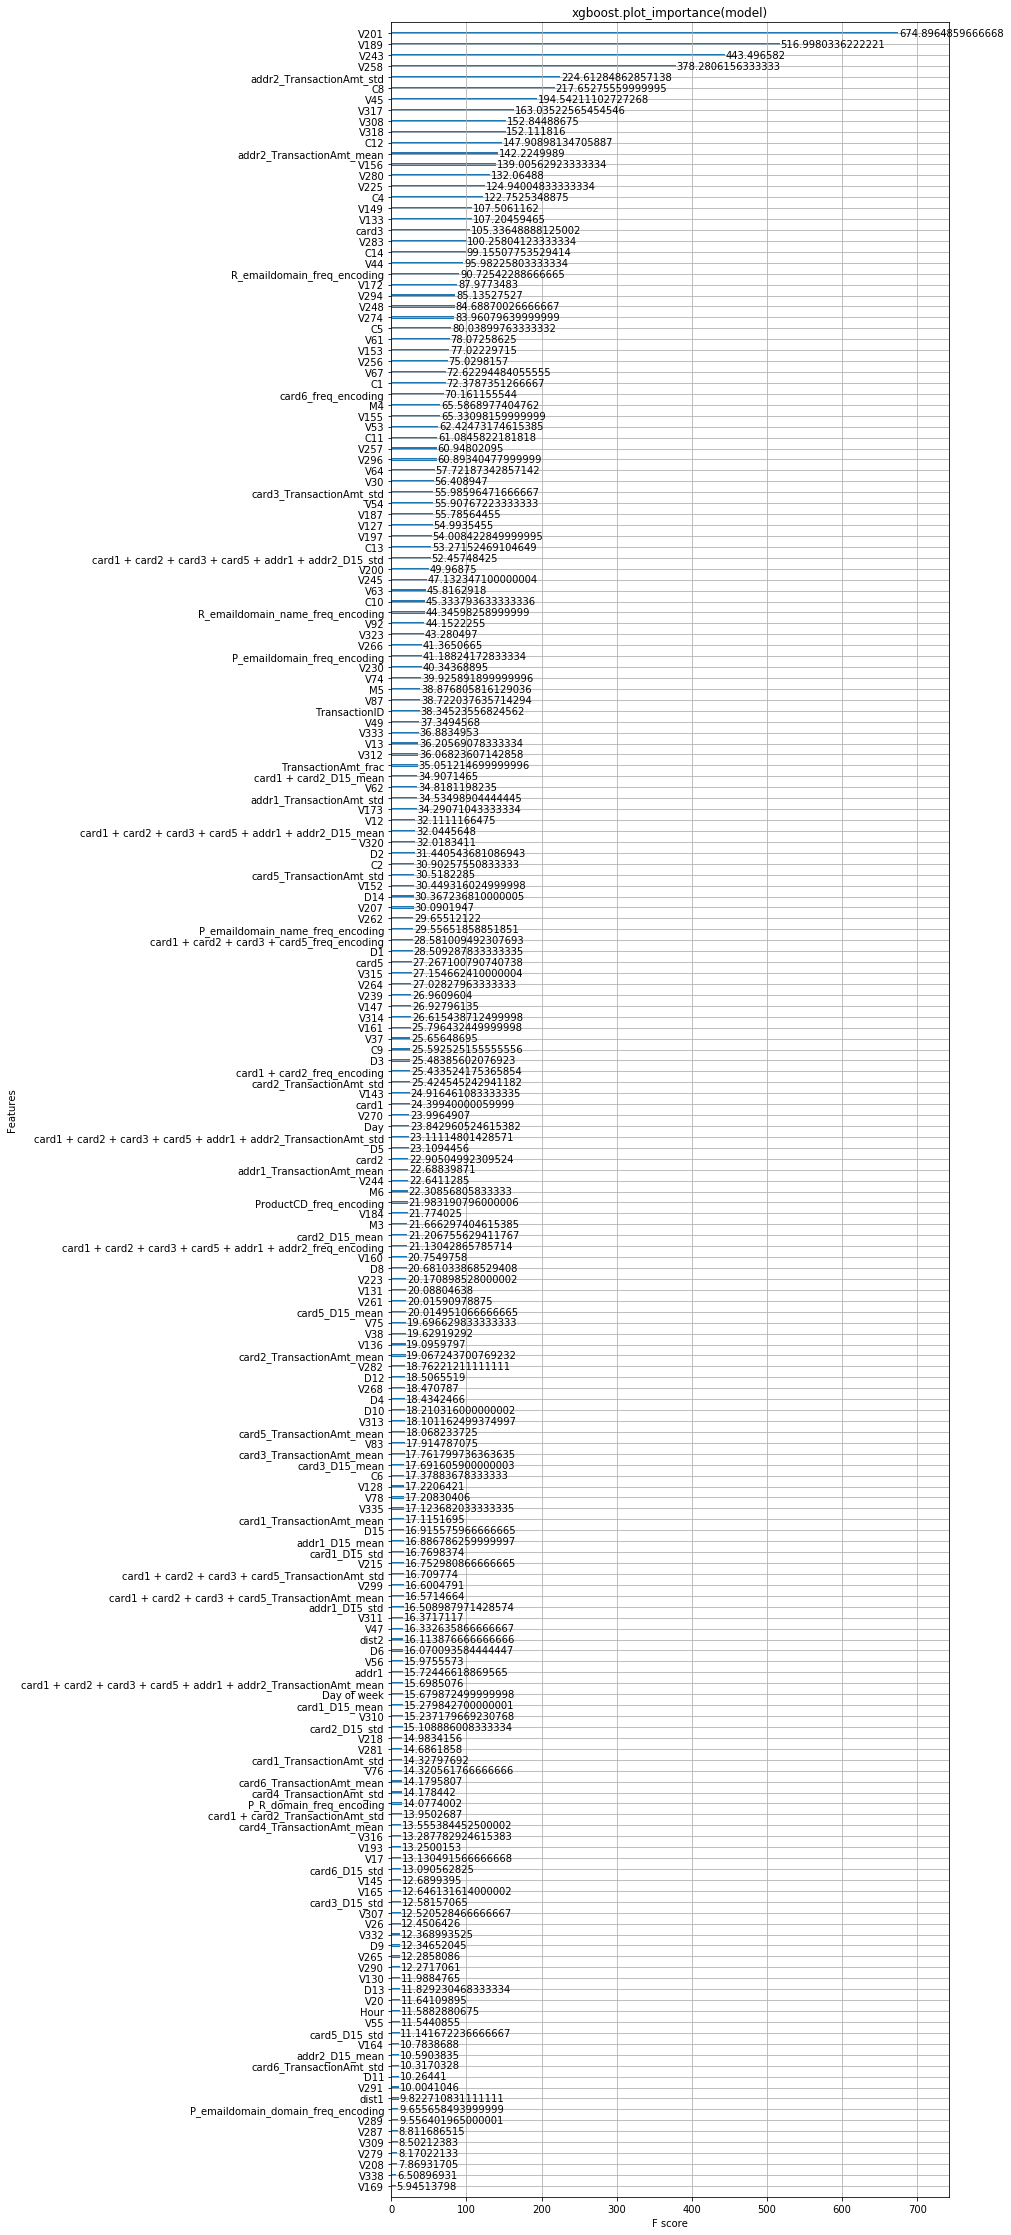

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(10, 40))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.title("xgboost.plot_importance(model)")
plt.show()
features = [k for k, v in model.get_score(importance_type='gain').items() if v > 20]

In [142]:
val_train, val_test = GroupKFold_val(x_train[features], y_train, n_split=5, group='card1 + card2 + card3 + card5 + addr1 + addr2_freq_encoding')

print(f"Train-score: {round(np.mean(val_train), 3)}+/- {round(np.std(val_train), 3)}, Test-score: {round(np.mean(val_test), 3)} +/- {round(np.std(val_test), 3)}")

[16:31:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train-score: 0.927, Test-score: 0.89
(0.8763779308229389, 0.9038149618631486)
[16:32:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train-score: 0.919, Test-score: 0.893
(0.8809292564712711, 0.903848236937977)
[16:33:09] WARNING: C:\Users\Administrator\workspace\xgboost-win

Train-score: 0.925, Test-score: 0.883
(0.8713479547901892, 0.8948684208900687)
Train-score: 0.923+/- 0.002, Test-score: 0.887 +/- 0.006

In [177]:
def _predict(estimator, x_valid):
    if hasattr(estimator, "predict_proba"):
        y_pred = estimator.predict_proba(x_valid)[:, 1]
    else:
        y_pred = estimator.predict(x_valid)

    return y_pred

def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.DataFrame,
                                     maximize: bool = True
                                     ) -> pd.Series:
    """
    Вычисление важности признаков на основе перестановочного
    критерия (permutation importance).

    Parameters
    ----------
    estimator: sklearn-API estimator
        Модель машинного обучения, выполненная в sklearn-API.
        Модель должны быть обученной (применен метод `fit`).

    metric: callable
        Функция для оценки качества прогнозов, функция принимает
        2 аргумента: вектор истинных ответов и вектор прогнозов.

    x_valid: pandas.core.frame.DataFrame
        Матрица признаков для оценки качества модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для оценки качества модели.

    maximize: bool, optional, default = True
        Флаг максимизации метрики качества.
        Опциональный параметр, по умолчанию, равен `True`.
        Если `True`, значит чем выше значение метрики качества,
        тем лучше. Если `False` - иначе.

    """
    y_pred = _predict(estimator, x_valid)
    base_score = metric(y_valid, y_pred)
    scores, delta = {}, {}

    for feature in x_valid.columns:
        x_valid_ = x_valid.copy(deep=True)
        x_valid_[feature] = np.random.permutation(x_valid_[feature])

        y_pred = _predict(estimator, x_valid_)
        feature_score = metric(y_valid, y_pred)

        if maximize:
            delta[feature] = base_score - feature_score
        else:
            delta[feature] = feature_score - base_score

        scores[feature] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

In [183]:

scores, importance = calculate_permutation_importance(
    model, roc_auc_score, x_train, y_train
)

In [184]:
importance

M4                     0.031228
C13                    0.008831
C14                    0.008751
D2                     0.006673
card6_freq_encoding    0.005890
                         ...   
V190                  -0.000075
V326                  -0.000092
V188                  -0.000096
V303                  -0.000131
V212                  -0.000172
Length: 453, dtype: float64

In [185]:
im_f = importance[importance>0].index.tolist()

In [186]:
val_train, val_test = GroupKFold_val(x_train[im_f], y_train, n_split=5, group='card1 + card2 + card3 + card5 + addr1 + addr2_freq_encoding')

print(f"Train-score: {round(np.mean(val_train), 3)}+/- {round(np.std(val_train), 3)}, Test-score: {round(np.mean(val_test), 3)} +/- {round(np.std(val_test), 3)}")

[20:53:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train-score: 0.927, Test-score: 0.89
(0.8765848141779178, 0.9029479879161523)
[20:55:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train-score: 0.925, Test-score: 0.89
(0.8782149335483201, 0.9009459838020053)
[20:56:57] WARNING: C:\Users\Administrator\workspace\xgboost-win

Train-score: 0.927, Test-score: 0.883
(0.8697999173669503, 0.8950113980067049)
Train-score: 0.925+/- 0.002, Test-score: 0.888 +/- 0.006

In [187]:
import numpy as np
import pandas as pd
import xgboost as xgb

from boostaroota import BoostARoota
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

def prepare_data(X: pd.DataFrame) -> pd.DataFrame:
    """
    Подготовка набора данных для моделирования.
    Категориальные признаки преобразуются с помощью
    OneHotEnconding.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков.

    """
    categorical = X.dtypes[X.dtypes=="object"].index.tolist()

    X = pd.get_dummies(X, columns=categorical)
    X.columns = [col.lower() for col in X.columns]
    
    return X

x_train = prepare_data(x_train)


br = BoostARoota(metric='auc', iters=50)
br.fit(x_train, y_train)

data_br =  br.transform(x_train)



[21:02:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  1  iteration:  1
[21:03:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  1  iteration:  2
[21:03:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to som

In [188]:
val_train, val_test = GroupKFold_val(data_br, y_train, n_split=5, group='card1 + card2 + card3 + card5 + addr1 + addr2_freq_encoding')

print(f"Train-score: {round(np.mean(val_train), 3)}+/- {round(np.std(val_train), 3)}, Test-score: {round(np.mean(val_test), 3)} +/- {round(np.std(val_test), 3)}")

[21:54:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train-score: 0.929, Test-score: 0.892
(0.8781485552673345, 0.9051192700594315)
[21:56:18] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train-score: 0.925, Test-score: 0.888
(0.8766951207869444, 0.8997109229328614)
[21:58:05] WARNING: C:\Users\Administrator\workspace\xgboost-w

Train-score: 0.927, Test-score: 0.881
(0.8689684311181024, 0.8929577315482555)
Train-score: 0.926+/- 0.003, Test-score: 0.887 +/- 0.007

In [189]:
import shap

In [258]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

In [247]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([x_train.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
col = importance_df.loc[importance_df['shap_importance']>0, 'column_name'].to_list()

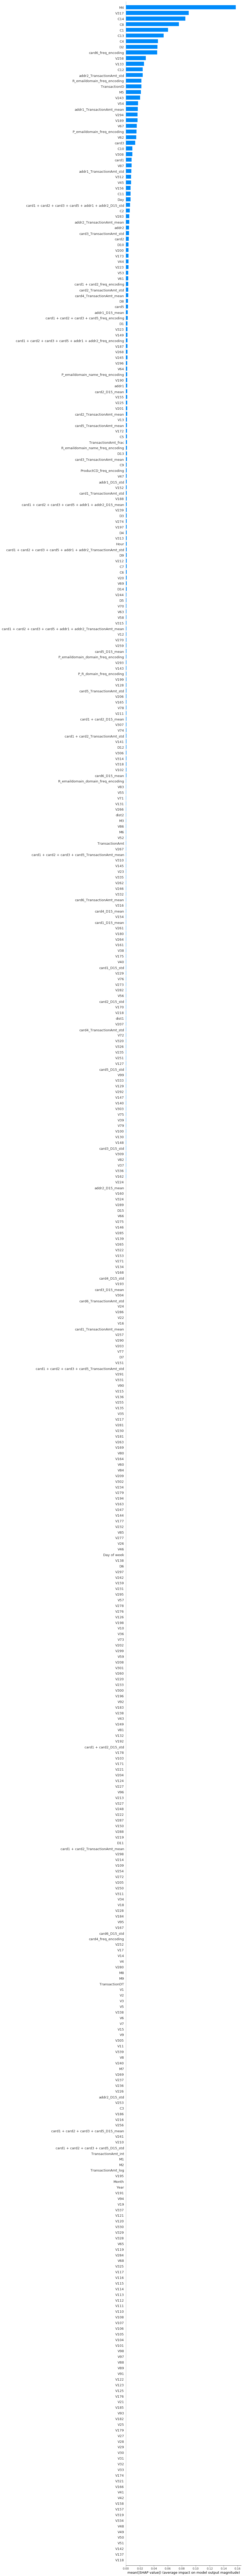

In [221]:
shap.summary_plot(shap_values, x_train, plot_type="bar", max_display=x_train.shape[1])

In [248]:
val_train, val_test = GroupKFold_val(x_train[col], y_train, n_split=5, group='card1 + card2 + card3 + card5 + addr1 + addr2_freq_encoding')

print(f"Train-score: {round(np.mean(val_train), 3)}+/- {round(np.std(val_train), 3)}, Test-score: {round(np.mean(val_test), 3)} +/- {round(np.std(val_test), 3)}")

[00:30:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train-score: 0.929, Test-score: 0.891
(0.8782501475503919, 0.9041595048368455)
[00:32:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Train-score: 0.922, Test-score: 0.892
(0.8794700184736356, 0.9035938182008835)
[00:34:03] WARNING: C:\Users\Administrator\workspace\xgboost-w

Train-score: 0.927, Test-score: __0.884__

(0.873308183268541, 0.8953935092704388)

Train-score: 0.925+/- 0.003, Test-score: 0.889 +/- 0.005

Признаки отобранные с помощью shape лучше всего повличли на качество модели.

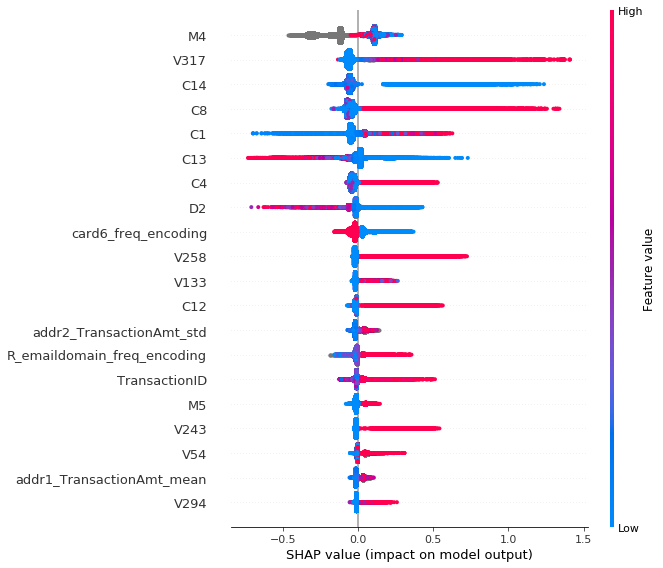

In [261]:
shap.summary_plot(shap_values, x_train)

Высокие значения признаков V317, C8, C4, V258, C12 и остальные ниже по графику увеличивают вероятность класса 1

Высокое значение признака С13 и D2 уменьшает вероятность

Признак M4 (серое пропуски?) пропущенные значения уменьшают вероятность.

In [251]:
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = x_train.iloc[select]
features_display = x_train.loc[features.index]
shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features)

if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: -3.543898582458496


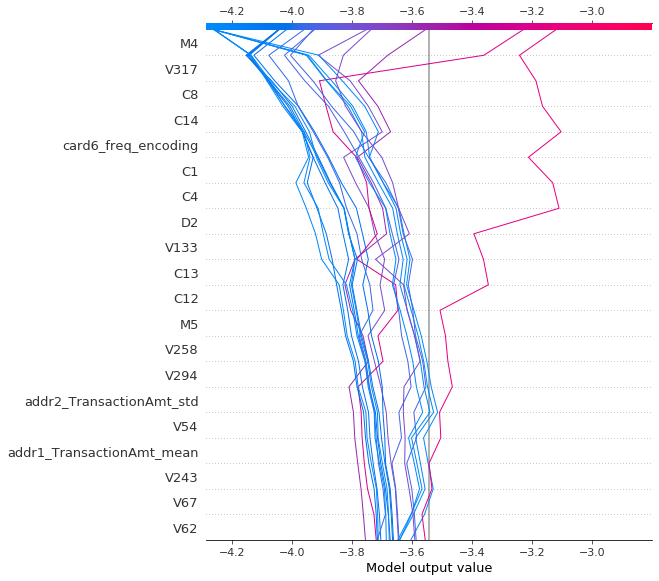

In [257]:
shap.decision_plot(
    expected_value, shap_values, features_display.iloc[:20]
)